In [6]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('science')
plt.rcParams['text.usetex'] = True
#import seaborn; seaborn.set()
import astropy.io.fits as fits
from astropy.io import ascii
from astropy.table import Table
import scipy.stats as stats
import os
import re
from pandas import DataFrame
import pandas as pd
import sys
# 定义颜色
colors = {
    'red': '#E24A33',
    'blue': '#348ABD',
    'green': '#8EBA42',
    'orange': '#FBC15E',
    'purple': '#988ED5',
    'pink': '#FFB5B8',
    'gray': '#777777'
}


def readfile(tfile): 
    with open(tfile,'r') as f:
        lines=f.readlines()
    return lines

In [7]:
source="/Volumes/WD_BLACK/Data/1A0535p262/HXMT/HHT/20201120_QPOphase/fit_results_fdcut"
path0="/Volumes/WD_BLACK/Data/1A0535p262/HXMT/HHT/20201120_QPOphase/fit_results_fdcut"
files=os.listdir("%s"%source)

In [8]:
# Models=['gabs','gaussian','fdcut']
# N_Units=[[1,1],[0],[0,0,0,0]]
# errs=[3,5,8,9,10,11,12]
# Long_index=[1,1,1]

Models=['gabs','gabs','gaussian','fdcut']
N_Units=[[1,1],[1,1,1],[0],[0,0,0,0]]
errs=[3,5,6,7,8,11,12,13,14,15]
Long_index=[2,1,1,1]

# Models=['gabs','fdcut']
# N_Units=[[1,1,1],[0,0,0,0]]
# errs=[3,4,5,9,10,11,12]
# Long_index=[1,1]


In [9]:
def read_fitresults(source,files,Models,N_Unitsi,path0):
    print(files)
    #MJD = read_MJD(files,path0)
    f = open("%s/%s"%(source,files),"r")
    all=f.read()
    #print(all)
    line_tails=readfile("%s/%s"%(source,files))
    #print(line_tails)
    j=0
    pars_values=[]
    pars_names=[]
    while j < len(Models):
        pars=re.findall(r"%s.*"%Models[j], all)
        #print(pars)
        l=len(N_Units[j])
        while l > 0:
            p=N_Units[j][-l]
            if Long_index[j] > 1:
                pars_values.append(float(pars[-l-(Long_index[j]-1)*len(N_Units[j+1])].split()[2+p]))
                #print(pars_values)
                name_str=Models[j]+'%s'%Long_index[j]+'_'+pars[-l].split()[1]
                pars_names.append(name_str)
                l-=1
            else:
                pars_values.append(float(pars[-l].split()[2+p]))
                name_str=Models[j]+'%s'%Long_index[j]+'_'+pars[-l].split()[1]
                pars_names.append(name_str)
                l-=1
        j+=1
    par_chi=re.findall(r"Test statistic : Chi-Squared.*", all)
    #print(par_chi[-1].split())
    dofall=re.findall(r"Null hypothesis probability.*", all)
    #print(dofall[-1].split())
    chi2=par_chi[-1].split()[4]
    # print(chi2)
    dof=dofall[-1].split()[6]
    # print(dof)
    red_chi2=float(chi2)/float(dof)
    # print(red_chi2)
    return pars_names, pars_values, red_chi2

In [10]:
def read_errs(source,files,errs,pars_names,pars_values):
    f = open("%s/%s"%(source,files),"r")
    all=f.read()
    #print(all)
    line_tails=readfile("%s/%s"%(source,files))
    Err=re.findall(r"Parameter   Credible Interval.*", all)
    l=0
    while l < len(line_tails):
        if Err[0] in line_tails[l]:
            L=l
        else:
            pass
        l+=1
    for e in errs:
        Errs_results=[line_tails[L+1+a].split() for a in range(len(errs))]
    pars_Err_lh=[]
    NE=0
    while NE < len(errs):
        err_low=float(Errs_results[NE][1])
        err_high=float(Errs_results[NE][2])
        pars_Err_lh.append([err_low,err_high])
        NE+=1
    #print(pars_values)
    #get err
    Np=0
    err_LR=[]
    while Np < len(pars_values):
        err_L=pars_values[Np]-pars_Err_lh[Np][0]
        err_R=pars_Err_lh[Np][1]-pars_values[Np]
        err_LR.append([err_L,err_R])
        Np+=1
    err_names_L=["%s_Lerrs"%Name for Name in pars_names]
    err_names_R=["%s_Rerrs"%Name for Name in pars_names]

    err_L=[i[0] for i in err_LR]
    err_R=[i[1] for i in err_LR]

    return err_names_L,err_L,err_names_R,err_R

In [11]:
i=0
red_chi2_all=[]
while i < len(files):
#while i < 1:
    #pars_names, pars_values,red_chi2,dof, MJD, Lum, Lum_errL, Lum_errR=read_fitresults(source,files[i],Models,N_Units,path0)
    pars_names, pars_values, red_chi2=read_fitresults(source,files[i],Models, N_Units,path0)
    red_chi2_all.append(red_chi2)
    #print(red_chi2)
    #print(pars_names)
    fit_names=pars_names
    fit_data=pars_values

    err_names_L, err_L, err_names_R, err_R=read_errs(source,files[i],errs,pars_names,pars_values)
    #print(err_names_L)
    #err_names_L, err_L = err_names_L+['Lum_errL'], err_L+[Lum_errL]
    #err_names_R, err_R = err_names_R+['Lum_errR'], err_R+[Lum_errR]
    
    derr_L=dict(zip(err_names_L,err_L))
    derr_R=dict(zip(err_names_R,err_R))
    if i==0:
        d1 = dict(zip(fit_names,fit_data))
        Para=pd.DataFrame(d1,index=['%s'%files[i]])
        Para_errL=pd.DataFrame(derr_L,index=['%s'%files[i]])
        Para_errR=pd.DataFrame(derr_R,index=['%s'%files[i]])
        i+=1
    else:
        Para.loc['%s'%files[i]]=fit_data
        Para_errL.loc['%s'%files[i]]=err_L
        Para_errR.loc['%s'%files[i]]=err_R
        i+=1
Para_all=pd.concat([Para,Para_errL,Para_errR],axis=1)
#save_data="fit_comptt_final.csv"
#Para_all.to_csv(save_data)

phase_0001.txt
phase_0102.txt
phase_0203.txt
phase_0304.txt
phase_0405.txt
phase_0506.txt
phase_0607.txt
phase_0708.txt
phase_0809.txt
phase_0910.txt


In [12]:
Para_all

,gabs2_Sigma,gabs2_Strength,gabs1_LineE,gabs1_Sigma,gabs1_Strength,gaussian1_norm,fdcut1_Gamma1,fdcut1_Ecut,fdcut1_Efold,fdcut1_norm,...,gabs2_Sigma_Rerrs,gabs2_Strength_Rerrs,gabs1_LineE_Rerrs,gabs1_Sigma_Rerrs,gabs1_Strength_Rerrs,gaussian1_norm_Rerrs,fdcut1_Gamma1_Rerrs,fdcut1_Ecut_Rerrs,fdcut1_Efold_Rerrs,fdcut1_norm_Rerrs
phase_0001.txt,106.844,7.22064,46.7069,12.5031,9.48112,0.059637,0.471778,14.6735,11.7511,2.14299,...,6.157,3.43136,0.4239,1.1071,1.85618,0.004659,0.009352,1.2572,0.0589,0.02882
phase_0102.txt,104.683,8.10983,45.4768,11.1563,5.51134,0.060912,0.480760,13.9609,11.9816,2.20187,...,2.474,2.65077,0.8707,1.6139,1.68115,0.004887,0.012776,1.4827,0.0443,0.01860
phase_0203.txt,107.288,13.89560,42.5435,12.6061,5.54642,0.050657,0.523444,17.8961,11.9367,2.12130,...,2.416,3.64500,0.7481,1.4534,1.74252,0.003761,0.006360,1.0769,0.1275,0.03322
phase_0304.txt,103.720,12.60250,40.4825,10.0236,2.86945,0.053532,0.544902,19.0555,12.1176,2.15601,...,2.187,2.41060,0.7042,2.3525,0.92528,0.001588,0.006660,0.9612,0.0741,0.02253
phase_0405.txt,104.083,13.79300,40.1051,10.0316,2.73344,0.058410,0.551486,20.1367,12.1688,2.16011,...,0.598,1.44840,0.7574,1.7792,1.35686,0.006500,0.014357,1.9603,0.0973,0.01247
phase_0506.txt,106.797,15.94060,39.6875,10.1829,3.18816,0.062465,0.548870,20.1111,12.1230,2.17021,...,2.658,2.27300,0.5779,1.6483,0.88260,0.003389,0.011278,1.3369,0.1296,0.02586
phase_0607.txt,105.863,10.98800,41.9164,11.2764,4.39218,0.053781,0.516617,17.9445,12.1266,2.14885,...,5.302,5.23240,0.8007,1.2413,1.56736,0.001563,0.013284,1.6695,0.0888,0.03027
phase_0708.txt,109.067,11.61150,44.3874,12.2960,6.30361,0.055865,0.493052,16.4343,12.0273,2.14264,...,2.342,4.89630,0.4619,1.2436,1.65750,0.007265,0.018223,1.6502,0.0783,0.04559
phase_0809.txt,109.479,9.95801,46.6217,12.3307,7.99221,0.055926,0.464272,14.4829,11.8938,2.18846,...,8.064,8.92929,0.3139,0.9316,1.36103,0.001597,0.013766,1.5619,0.0350,0.01285
phase_0910.txt,108.733,5.80326,47.0869,12.8230,10.38640,0.060887,0.466146,14.7021,11.7145,2.17229,...,4.557,0.53725,0.3005,0.7664,1.94050,0.005744,0.013514,1.6197,0.0465,0.02629


In [13]:
red_chi2_all=np.array(red_chi2_all)
red_chi2_all

array([0.95585205, 0.91774406, 0.94210596, 0.91695251, 0.99092348,
       1.01707031, 0.94997372, 0.89666232, 0.86743155, 1.03563233])

In [14]:
# array([1.02469291, 1.04010963, 1.00483516, 0.98260734, 1.03002324,
#        1.00123267, 0.96921947, 1.0378577 , 1.0424181 , 1.03605942])
# array([1.05194988, 1.0372352 , 1.00356753, 1.00218944, 1.05700308,
#        1.01504215, 0.97053036, 1.04151538, 1.05785881, 1.04276827])
# array([1.12392801, 1.05589883, 1.00779251, 1.07849496, 1.1295535 ,
#        1.07886677, 0.97735023, 1.05447348, 1.11148837, 1.12940948])

In [15]:
print(Para_all.columns)
M=len(errs)
print(M)
names=Para_all.columns[:M]
print(names)

Index(['gabs2_Sigma', 'gabs2_Strength', 'gabs1_LineE', 'gabs1_Sigma',
       'gabs1_Strength', 'gaussian1_norm', 'fdcut1_Gamma1', 'fdcut1_Ecut',
       'fdcut1_Efold', 'fdcut1_norm', 'gabs2_Sigma_Lerrs',
       'gabs2_Strength_Lerrs', 'gabs1_LineE_Lerrs', 'gabs1_Sigma_Lerrs',
       'gabs1_Strength_Lerrs', 'gaussian1_norm_Lerrs', 'fdcut1_Gamma1_Lerrs',
       'fdcut1_Ecut_Lerrs', 'fdcut1_Efold_Lerrs', 'fdcut1_norm_Lerrs',
       'gabs2_Sigma_Rerrs', 'gabs2_Strength_Rerrs', 'gabs1_LineE_Rerrs',
       'gabs1_Sigma_Rerrs', 'gabs1_Strength_Rerrs', 'gaussian1_norm_Rerrs',
       'fdcut1_Gamma1_Rerrs', 'fdcut1_Ecut_Rerrs', 'fdcut1_Efold_Rerrs',
       'fdcut1_norm_Rerrs'],
      dtype='object')
10
Index(['gabs2_Sigma', 'gabs2_Strength', 'gabs1_LineE', 'gabs1_Sigma',
       'gabs1_Strength', 'gaussian1_norm', 'fdcut1_Gamma1', 'fdcut1_Ecut',
       'fdcut1_Efold', 'fdcut1_norm'],
      dtype='object')


In [16]:
#20201120
phase_bins=np.array([0.06255528, 0.1250455 , 0.18753573, 0.25002596, 0.31251619,
        0.37500641, 0.43749664, 0.49998687, 0.5624771 , 0.62496732,
        0.68745755, 0.74994778, 0.812438  , 0.87492823, 0.93741846,
        0.99990869, 1.06255528, 1.1250455 , 1.18753573, 1.25002596,
        1.31251619, 1.37500641, 1.43749664, 1.49998687, 1.5624771 ,
        1.62496732, 1.68745755, 1.74994778, 1.812438  , 1.87492823,
        1.93741846, 1.99990869])
profile=np.array([378.17692704, 383.39111481, 422.79334628, 459.27246448,
        503.46954949, 552.90630786, 592.35956009, 605.05959758,
        598.71286637, 590.6512502 , 547.03194704, 501.56012292,
        459.62509799, 422.70982058, 396.91126756, 380.48669774,
        378.17692704, 383.39111481, 422.79334628, 459.27246448,
        503.46954949, 552.90630786, 592.35956009, 605.05959758,
        598.71286637, 590.6512502 , 547.03194704, 501.56012292,
        459.62509799, 422.70982058, 396.91126756, 380.48669774])

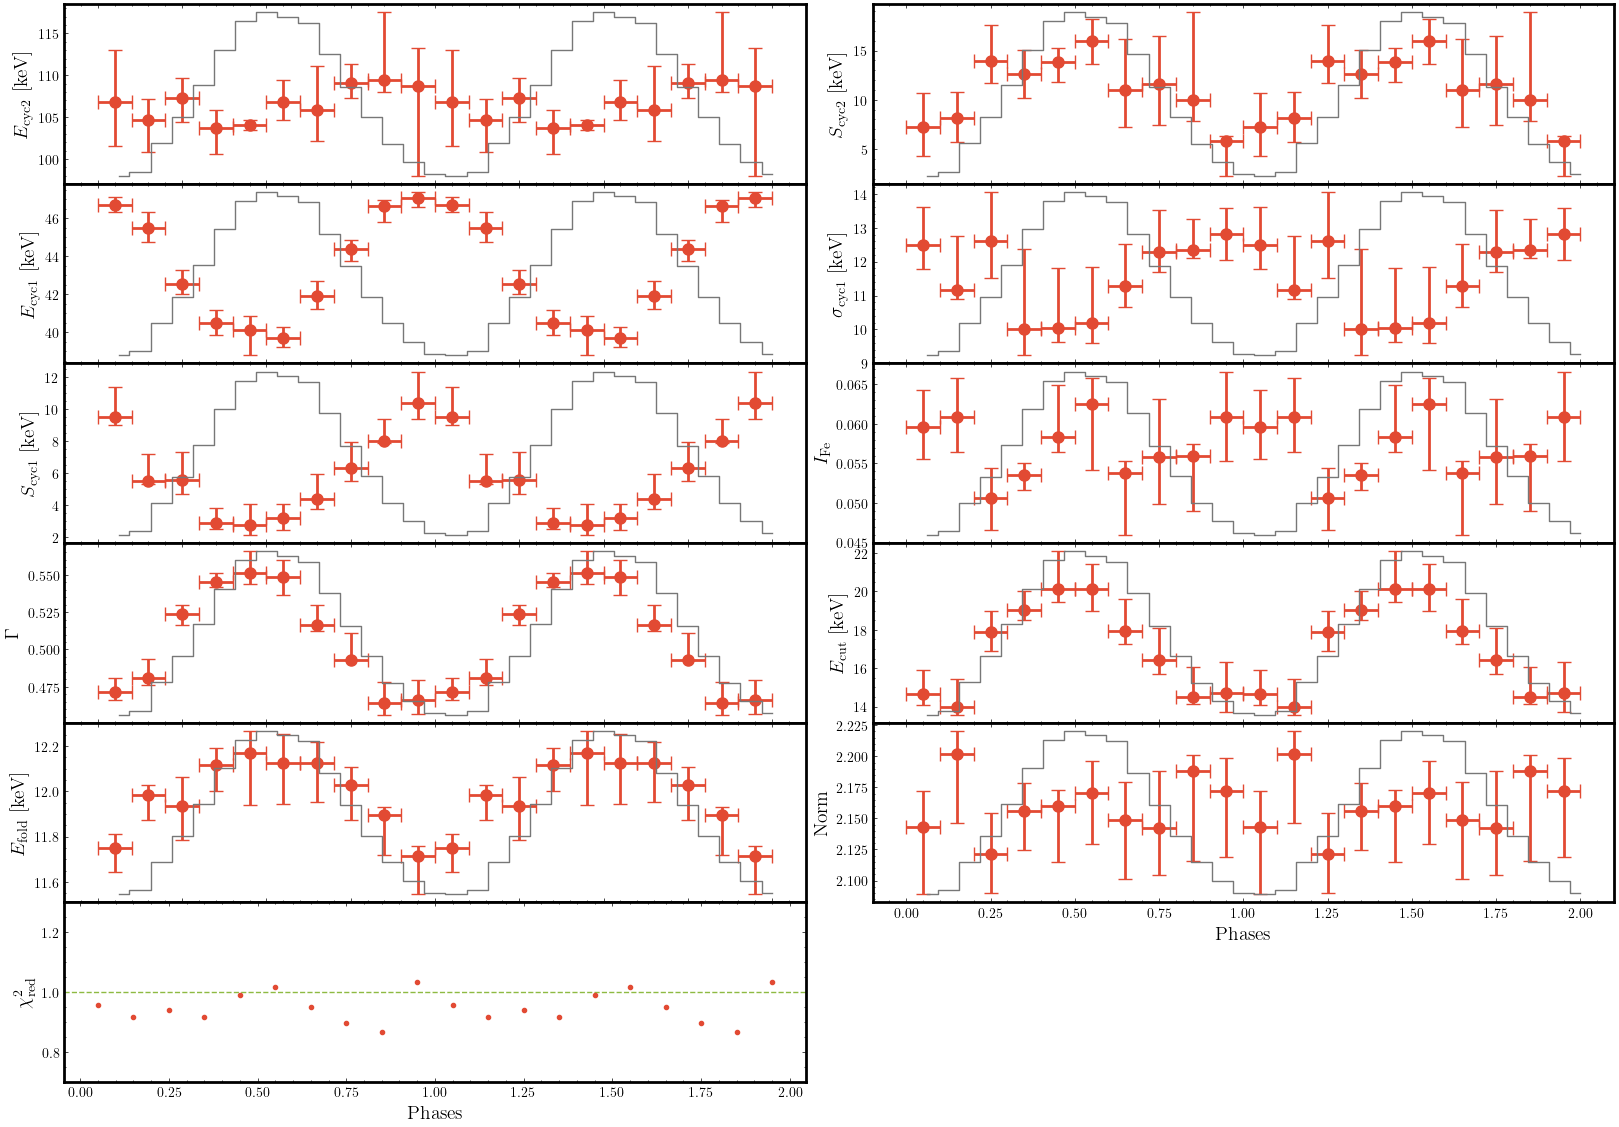

In [17]:
X = np.array([0.05,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95])
x_data=np.hstack([X,X+1])
X_err=np.array([0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05])
x_err=np.hstack([X_err,X_err])
fig, axs = plt.subplots((M)//2+1, 2, figsize=(20, 14))
axs = axs.flatten()
#fig, axs = plt.subplots(M+1,1,figsize=(4, 16))
Ylabels=names
Ylabels=[r'$E_{\rm cyc2}$ [keV]',r'$S_{\rm cyc2}$ [keV]', 
         r'$E_{\rm cyc1}$ [keV]', r'$\sigma_{\rm cyc1}$ [keV]', r'$S_{\rm cyc1}$ [keV]', 
         r'$I_{\rm Fe}$', 
         r'$\Gamma$', r'$E_{\rm cut}$ [keV]', r'$E_{\rm fold}$ [keV]', r'Norm']
i=0
while i < len(names):
    name=names[i]
    y1=Para_all['%s'%name].values
    #print(np.mean(y1))
    y1_err=[abs(Para_all['%s_Lerrs'%name].values),abs(Para_all['%s_Rerrs'%name].values)]
    y1=np.hstack([y1,y1])
    #y1=abs(y1)
    y1_err=np.hstack([y1_err,y1_err])
    y1_err=abs(y1_err)
    axs[0+i].errorbar(x_data, y1, xerr=x_err, yerr=y1_err, 
                      fmt='o', color=colors['red'], ecolor=colors['red'], capsize=5, markersize=8, elinewidth=2)
    axs2 = axs[0+i].twinx()
    axs2.errorbar(phase_bins, profile/np.mean(profile), 
                  drawstyle='steps-mid',color=colors['gray'],ecolor=colors['gray'])
    #axs2.errorbar(phase_bins2, profile2/np.mean(profile2), drawstyle='steps-mid',color='b',ecolor='b',alpha=0.5)
    axs2.set_yticks([])
    axs[0+i].set_ylabel(Ylabels[i],fontsize=14, fontweight='bold',fontname='Times New Roman')
    axs[i].spines['top'].set_linewidth(2)
    axs[i].spines['right'].set_linewidth(2)
    axs[i].spines['bottom'].set_linewidth(2)
    axs[i].spines['left'].set_linewidth(2)
    i+=1
#plot reduced chi^2 of fitting: 
axs[0+i].errorbar(x_data,np.hstack([red_chi2_all,red_chi2_all]),fmt='.',color=colors['red'],ecolor=colors['red'])
axs[0+i].axhline(y=1, color=colors['green'], linestyle='--',lw=1)
axs[0+i].set_ylim(0.7,1.3)
#axs[0+i].set_xlim(0.0,2.0)
#设置边框
axs[i].spines['top'].set_linewidth(2)
axs[i].spines['right'].set_linewidth(2)
axs[i].spines['bottom'].set_linewidth(2)
axs[i].spines['left'].set_linewidth(2)
# 移除最后一个子图
fig.delaxes(axs[-1])
axs[-3].set_xlabel('Phases',fontsize=14, fontweight='bold',fontname='Times New Roman')
axs[0+i].set_ylim(0.7,1.3)
axs[0+i].set_ylabel(r'$\chi^2_{\rm red}$',fontsize=14, fontweight='bold',fontname='Times New Roman')
axs[0+i].set_xlabel('Phases',fontsize=14, fontweight='bold',fontname='Times New Roman')
plt.subplots_adjust(wspace=0.09,hspace=0)
#plt.savefig('/Users/kldsky/Desktop/1A0535_results/fdcut/20201120_fdcut.pdf')

In [18]:
for i in names:
    rms=100*(max(abs(Para_all[i].values))-(min(abs(Para_all[i].values))))/(abs(max(Para_all[i].values))+min(abs(Para_all[i].values)))
    K=np.mean(Para_all[i].values)
    #print('rms:',rms)
    print('mean:',i,K)

mean: gabs2_Sigma 106.6557
mean: gabs2_Strength 10.992294
mean: gabs1_LineE 43.50147
mean: gabs1_Sigma 11.52297
mean: gabs1_Strength 5.840433
mean: gaussian1_norm 0.05720719
mean: fdcut1_Gamma1 0.5061327000000001
mean: fdcut1_Ecut 16.93976
mean: fdcut1_Efold 11.9841
mean: fdcut1_norm 2.160473


chi2 (constant model): 495.75
Degrees of freedom (constant model): 19
chi2 (sin model): 3.50
Degrees of freedom (sin model): 16
F value: 749.05
p value: 1.110223e-16
Sigma: 8.21
P-value: 1.110223e-16


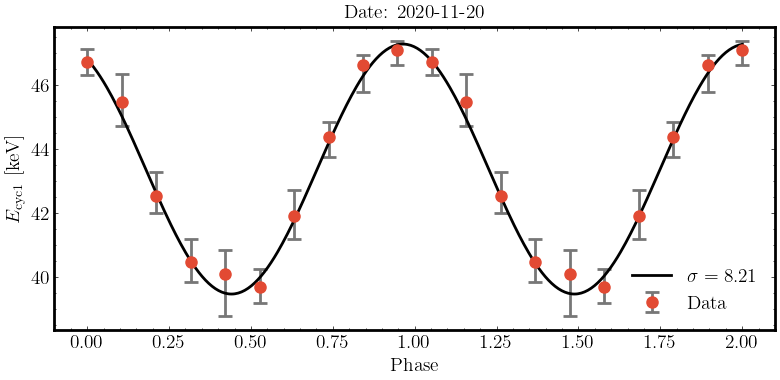

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import chi2
import scipy.stats as stats

# 定义常数函数和正弦函数
def const_func(x, C):
    return C

def sin_func(x, A, omega, phi, C):
    return A * np.cos(omega * x + phi) + C

# 数据
name0 = 'gabs1_LineE'
x = np.linspace(0, 2, 20)
# 这里需要使用实际数据集 Para_all，如果没有数据，可以用随机数据代替
y1 = Para_all['%s' % name0].values
y1_errL = abs(Para_all['%s_Lerrs' % name0].values)
y1_errR = abs(Para_all['%s_Rerrs' % name0].values)
# 示例数据
# y1 = np.random.rand(20)  # 请用实际数据替换
# y1_errL = np.random.rand(20) * 0.1  # 请用实际数据替换
# y1_errR = np.random.rand(20) * 0.1  # 请用实际数据替换

y1 = np.hstack([y1, y1])
y1_errL = np.hstack([y1_errL, y1_errL])
y1_errR = np.hstack([y1_errR, y1_errR])

y_edge1_MaxTau = y1
y_err_lower_edge1_MaxTau = y1_errL
y_err_upper_edge1_MaxTau = y1_errR
y_err_edge1_MaxTau = (y_err_lower_edge1_MaxTau + y_err_upper_edge1_MaxTau) / 2

# 常数函数拟合
params_const, _ = curve_fit(const_func, x, y_edge1_MaxTau, sigma=y_err_edge1_MaxTau, absolute_sigma=True)
y_fit_const = const_func(x, *params_const)
chi2_const = np.sum(((y_edge1_MaxTau - y_fit_const) / y_err_edge1_MaxTau) ** 2)
dof_const = len(y_edge1_MaxTau) - len(params_const)

# 正弦函数拟合
params_sin, params_covariance_sin = curve_fit(sin_func, x, y_edge1_MaxTau, sigma=y_err_edge1_MaxTau, absolute_sigma=True, 
                                              p0=[40, 2*np.pi, 0, 0.4])
y_fit_sin = sin_func(x, *params_sin)
chi2_sin = np.sum(((y_edge1_MaxTau - y_fit_sin) / y_err_edge1_MaxTau) ** 2)
dof_sin = len(y_edge1_MaxTau) - len(params_sin)

# 计算 F 值
F_value = ((chi2_const - chi2_sin) / (dof_const - dof_sin)) / (chi2_sin / dof_sin)

# 计算 p 值
p_value = 1 - stats.f.cdf(F_value, dof_const - dof_sin, dof_sin)

# 输出结果
print(f"chi2 (constant model): {chi2_const:.2f}")
print(f"Degrees of freedom (constant model): {dof_const}")
print(f"chi2 (sin model): {chi2_sin:.2f}")
print(f"Degrees of freedom (sin model): {dof_sin}")
print(f"F value: {F_value:.2f}")
print(f"p value: {p_value:.6e}")  # 使用科学计数法显示非常小的p值

# 计算 Z 分数（标准差数）
z_score = stats.norm.ppf(1 - p_value)  # 使用 1 - p_value 计算Z分数

# 使用更多的点使得拟合线条更平滑
x_smooth = np.linspace(0, 2, 400)
y_fit_smooth_sin = sin_func(x_smooth, *params_sin)

# 绘制拟合结果图像
fig, ax = plt.subplots(figsize=(8, 4))

# 绘制数据点和误差棒
ax.errorbar(x, y_edge1_MaxTau, yerr=[y_err_lower_edge1_MaxTau, y_err_upper_edge1_MaxTau], fmt='o', label='Data', color=colors['red'], ecolor=colors['gray'], elinewidth=2, capsize=5, capthick=2, markersize=8)

# 添加 sigma 值的文本
textstr = r'$\sigma=%.2f$' % (z_score, )

# 绘制平滑后的拟合正弦波
ax.plot(x_smooth, y_fit_smooth_sin, label=textstr, color='black', linewidth=2)

# 设置文本框的外观
#props = dict(boxstyle='round', facecolor='white', alpha=0.5)
#ax.text(0.25, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top')

# 设置标签和标题
ax.set_xlabel('Phase', fontsize=14, fontweight='bold',fontname='Times New Roman')
ax.set_ylabel(r'$E_{\rm cyc1}$ [keV]', fontsize=14, fontweight='bold',fontname='Times New Roman')
# 显示图例
ax.legend(loc='lower right', fontsize=14)

# 去掉网格
ax.grid(False)

# 调整刻度和刻度标签
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_title('Date: 2020-11-20', fontsize=14, fontweight='bold',fontname='Times New Roman')
# 美化图形外观
fig.tight_layout()
# 保存图像为PDF（如需要）
#fig.savefig("/Users/kldsky/Desktop/1A0535_results/fdcut/20201120_fdcut_sigma.pdf")
print(f"Sigma: {z_score:.2f}")
print(f"P-value: {p_value:.6e}")

In [21]:
print(np.mean(Para_all['%s' % name0].values)),print(np.max(Para_all['%s' % name0].values)),print(np.min(Para_all['%s' % name0].values))

43.50147
47.0869
39.6875


(None, None, None)

In [28]:
print([np.array(Para_all['%s' % name0].values)])
print([Para_all['%s_Lerrs' % name0].values,Para_all['%s_Rerrs' % name0].values])

[array([46.7069, 45.4768, 42.5435, 40.4825, 40.1051, 39.6875, 41.9164,
       44.3874, 46.6217, 47.0869])]
[array([0.39  , 0.7508, 0.5476, 0.6376, 1.3202, 0.4741, 0.7096, 0.6309,
       0.8281, 0.4714]), array([0.4239, 0.8707, 0.7481, 0.7042, 0.7574, 0.5779, 0.8007, 0.4619,
       0.3139, 0.3005])]
